<a href="https://colab.research.google.com/github/IFuentesSR/Reservoir_area_Sentinel2/blob/main/HarmonizationL8_S2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=I8wV0K39L8B0cCDPrU0P9X59IKfi899cd5z8uAnibJI&tc=UakHxmJrjxX--8l0k5ZgmMp_RY_VKInGl0WucsB2q8Q&cc=pGmBwUbQz8OwmqNwd9nG21LMgqrWp01KOrIZH3LTfmc

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWiXzwsPeBrQkXTTAebfC1iBzhZCLFvyNX7Zd1yoVCWZ-kR0cT_mhDo

Successfully saved authorization token.


In [5]:
# Folium setup.
import os
import folium
import datetime
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import pearsonr


print(folium.__version__)

0.8.3


In [50]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
bands_sentinel = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
bands_landsat = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
geometry = ee.Geometry.Polygon(
    [[[149.54404094659114, -30.179943359491336],
      [149.54404094659114, -30.22148458539816],
      [149.60995891534114, -30.22148458539816],
      [149.60995891534114, -30.179943359491336]]], None, False)

## Sentinel 2 SR

In [35]:
def getS2_CLOUD_PROBABILITY(geo):
    innerJoined = ee.Join.inner().apply(primary=ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED").filterBounds(geo).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 40)),
                                        secondary=ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY").filterBounds(geo),
                                        condition=ee.Filter.equals(leftField='system:index',
                                                                   rightField='system:index'))
    def mergeImageBands(joinResult):
        return ee.Image(joinResult.get('primary')).addBands(joinResult.get('secondary'))

    newCollection = innerJoined.map(mergeImageBands)
    return ee.ImageCollection(newCollection)


def projectShadows(cloudMask, sunAzimuth, offset):
    azimuth = ee.Number(sunAzimuth).multiply(np.pi).divide(180.0).add(ee.Number(0.5).multiply(np.pi))
    x = azimuth.cos().multiply(15.0).round()
    y = azimuth.sin().multiply(15.0).round()
    shadow = cloudMask.changeProj(cloudMask.projection(), cloudMask.projection().translate(x.multiply(ee.Number(offset)), y.multiply(ee.Number(offset))))
    return shadow


def masking(img):
    props = img.propertyNames()
    clouds = img.select('SCL').eq(3)
    clouds2 = img.select('SCL').gt(7).And(img.select('SCL').lt(10))
    Clouds = img.select('probability').gte(40).selfMask()
    coarseClouds = Clouds.reduceResolution('count').reproject(crs=Clouds.projection().crs(), scale=50)
    coarseClouds = ee.Image(0).where(coarseClouds.eq(40), 1)
    coarseClouds = coarseClouds.fastDistanceTransform().sqrt().lt(3)
    # clouds = img.select('probability').gte(30)
    shadows = projectShadows(coarseClouds,
                             img.get('MEAN_SOLAR_AZIMUTH_ANGLE'), 
                             img.get('MEAN_INCIDENCE_ZENITH_ANGLE_B10'))
    shadow_distance = shadows.fastDistanceTransform().sqrt()
    #Threshold on distance (five pixels) for a dilation.
    shadow_dilation = shadow_distance.lt(5)
    mask = clouds.Not().And(shadow_dilation.Not()).And(coarseClouds.Not()).And(clouds2.Not())
    return img.updateMask(mask).select(bands_sentinel).multiply(0.0001).copyProperties(img, props)

In [36]:
s2 = getS2_CLOUD_PROBABILITY(geometry)
s2 = s2.map(masking)

## Landsat 8 SR



In [9]:
def mask(img):
    props = img.propertyNames()
    qua = img.select('QA_PIXEL')
    clouds = qua.bitwiseAnd(8).eq(0)
    cirrus = qua.bitwiseAnd(4).eq(0)
    shadows = qua.bitwiseAnd(16).eq(0)
    dilatedClouds = qua.bitwiseAnd(2).eq(0)
    masks = clouds.And(cirrus).And(shadows).And(dilatedClouds)
    return img.multiply(0.0000275).add(-0.2).updateMask(masks).select(bands_landsat).copyProperties(img, props)


def to_date(i):
  return ee.Date(i).format('YYYY-MM-dd')

In [22]:
l8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
l8 = l8.filterBounds(geometry).map(mask)

## Simple rule of three (from sentinel to landsat)
### Joining collections by a time window of 6 days (3 by side)

In [38]:
threeDaysMillis = 3 * 24 * 60 * 60 * 1000

timeFilter = ee.Filter.Or(ee.Filter.maxDifference(difference=threeDaysMillis,
                                                  leftField='system:time_start',
                                                  rightField= 'system:time_end'),
                          ee.Filter.maxDifference(difference=threeDaysMillis,
                                                  leftField='system:time_end',
                                                  rightField='system:time_start'))

saveAllJoin = ee.Join.saveAll(matchesKey='s2',
                              ordering='system:time_start',
                              ascending=True)

landsatSentinel = saveAllJoin.apply(l8, s2, timeFilter)

### Then rule of three

In [39]:
l8_img = landsatSentinel.first()
s2_img = ee.Image(ee.List(l8_img.get('s2')).get(0))

s2_img2 = s2.filterDate(ee.Date(s2_img.get('system:time_start')), '2022-05-01').first()
l8_img2 = s2_img2.multiply(l8_img).divide(s2_img) # unknown (from sentinel to landsat)

In [40]:
l8_fromS2 = l8_img2.getMapId({'min':0, 'max':0.3, 'bands':['B8', 'B4', 'B3']})
s2_original = s2_img2.getMapId({'min':0, 'max':0.3, 'bands':['B8', 'B4', 'B3']})
centroid = geometry.centroid(1).getInfo()['coordinates'][::-1]
map = folium.Map(location=centroid, zoom_start=14)
folium.TileLayer(
    tiles =s2_original['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='s2Original',
  ).add_to(map)
folium.TileLayer(
    tiles=l8_fromS2['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='l8derived',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

## Sampling pixels and linear regression
Joining collections by same date of acquisition 

In [41]:
threeDaysMillis = 0.5 * 24 * 60 * 60 * 1000

timeFilter = ee.Filter.Or(ee.Filter.maxDifference(difference=threeDaysMillis,
                                                  leftField='system:time_start',
                                                  rightField= 'system:time_end'),
                          ee.Filter.maxDifference(difference=threeDaysMillis,
                                                  leftField='system:time_end',
                                                  rightField='system:time_start'))

saveAllJoin = ee.Join.saveAll(matchesKey='s2',
                              ordering='system:time_start',
                              ascending=True)

landsatSentinel = saveAllJoin.apply(l8, s2, timeFilter)

In [48]:
def sampling(img):
    img = ee.Image(img)
    geo1 = ee.Geometry.Polygon(ee.Geometry(img.get('system:footprint')).coordinates())
    geo2 = ee.Geometry.Polygon(ee.Geometry(ee.Image(ee.List(img.get('s2')).get(0)).get('system:footprint')).coordinates())
    intersection = geo1.intersection(geo2)
    samples = ee.FeatureCollection.randomPoints(intersection, 1000)
    joined = img.addBands(ee.Image(ee.List(img.get('s2')).get(0)))
    sampled = joined.sampleRegions(collection=samples, scale=30)
    return sampled

In [53]:
samples = landsatSentinel.map(sampling)
ee.batch.Export.table.toDrive(collection=samples.flatten(), description='samples', fileNamePrefix='samples').start()

In [83]:
df = pd.read_csv('/content/drive/MyDrive/samples.csv')
df = df.dropna(how='any')
df_train = df.sample(frac=0.5)
df_test = df.drop(df_train.index)

In [85]:
from sklearn import linear_model

reg2 = linear_model.LinearRegression()
reg2.fit(df['B2'].values.reshape(-1, 1), df['SR_B2'].values.reshape(-1, 1))
slope2 = reg2.coef_
inter2 = reg2.intercept_

reg3 = linear_model.LinearRegression()
reg3.fit(df['B3'].values.reshape(-1, 1), df['SR_B3'].values.reshape(-1, 1))
slope3 = reg3.coef_
inter3 = reg3.intercept_

reg4 = linear_model.LinearRegression()
reg4.fit(df['B4'].values.reshape(-1, 1), df['SR_B4'].values.reshape(-1, 1))
slope4 = reg4.coef_
inter4 = reg4.intercept_

reg5 = linear_model.LinearRegression()
reg5.fit(df['B8'].values.reshape(-1, 1), df['SR_B5'].values.reshape(-1, 1))
slope5 = reg5.coef_
inter5 = reg5.intercept_

reg6 = linear_model.LinearRegression()
reg6.fit(df['B11'].values.reshape(-1, 1), df['SR_B6'].values.reshape(-1, 1))
slope6 = reg6.coef_
inter6 = reg6.intercept_

reg7 = linear_model.LinearRegression()
reg7.fit(df['B12'].values.reshape(-1, 1), df['SR_B7'].values.reshape(-1, 1))
slope7 = reg7.coef_
inter7 = reg7.intercept_


In [96]:

df_test['harmonB2'] = df_test['B2'] * slope2[0][0] + inter2[0]
df_test['harmonB3'] = df_test['B3'] * slope3[0][0] + inter3[0]
df_test['harmonB4'] = df_test['B4'] * slope4[0][0] + inter4[0]
df_test['harmonB5'] = df_test['B8'] * slope5[0][0] + inter5[0]
df_test['harmonB6'] = df_test['B11'] * slope6[0][0] + inter6[0]
df_test['harmonB7'] = df_test['B12'] * slope7[0][0] + inter7[0]

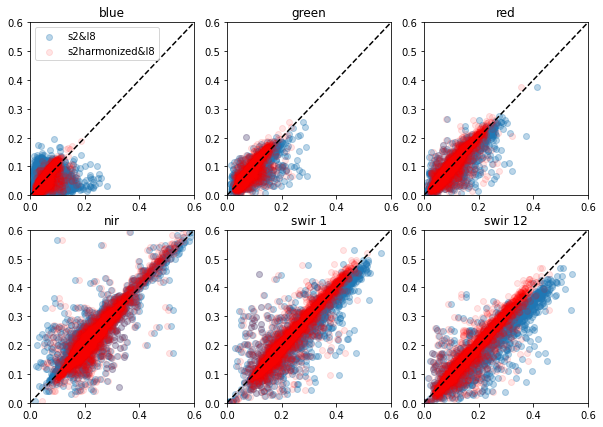

In [147]:
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
ax[0, 0].scatter(df_test['B2'], df_train['SR_B2'], alpha=0.3, label='s2&l8')
ax[0, 0].scatter(df_test['harmonB2'], df_test['SR_B2'], alpha=0.1, c='r', label='s2harmonized&l8')
ax[0, 0].set_title('blue')
ax[0, 0].plot(np.linspace(0, 0.6, 100), np.linspace(0, 0.6, 100), ls='--', color='k')
ax[0, 0].set_xlim(0, 0.6)
ax[0, 0].set_ylim(0, 0.6)
ax[0, 0].legend()
ax[0, 1].scatter(df_test['B3'], df_test['SR_B3'], alpha=0.3)
ax[0, 1].scatter(df_test['harmonB3'], df_test['SR_B3'], alpha=0.1, c='r')
ax[0, 1].set_title('green')
ax[0, 1].plot(np.linspace(0, 0.6, 100), np.linspace(0, 0.6, 100), ls='--', color='k')
ax[0, 1].set_xlim(0, 0.6)
ax[0, 1].set_ylim(0, 0.6)
ax[0, 2].scatter(df_test['B4'], df_test['SR_B4'], alpha=0.3)
ax[0, 2].scatter(df_test['harmonB4'], df_test['SR_B4'], alpha=0.1, c='r')
ax[0, 2].set_title('red')
ax[0, 2].plot(np.linspace(0, 0.6, 100), np.linspace(0, 0.6, 100), ls='--', color='k')
ax[0, 2].set_xlim(0, 0.6)
ax[0, 2].set_ylim(0, 0.6)
ax[1, 0].scatter(df_test['B8'], df_test['SR_B5'], alpha=0.3)
ax[1, 0].scatter(df_test['harmonB5'], df_test['SR_B5'], alpha=0.1, c='r')
ax[1, 0].set_title('nir')
ax[1, 0].plot(np.linspace(0, 0.6, 100), np.linspace(0, 0.6, 100), ls='--', color='k')
ax[1, 0].set_xlim(0, 0.6)
ax[1, 0].set_ylim(0, 0.6)
ax[1, 1].scatter(df_test['B11'], df_test['SR_B6'], alpha=0.3)
ax[1, 1].scatter(df_test['harmonB6'], df_test['SR_B6'], alpha=0.1, c='r')
ax[1, 1].set_title('swir 1')
ax[1, 1].plot(np.linspace(0, 0.6, 100), np.linspace(0, 0.6, 100), ls='--', color='k')
ax[1, 1].set_xlim(0, 0.6)
ax[1, 1].set_ylim(0, 0.6)
ax[1, 2].scatter(df_test['B12'], df_test['SR_B7'], alpha=0.3)
ax[1, 2].scatter(df_test['harmonB7'], df_test['SR_B7'], alpha=0.1, c='r')
ax[1, 2].set_title('swir 12')
ax[1, 2].plot(np.linspace(0, 0.6, 100), np.linspace(0, 0.6, 100), ls='--', color='k')
ax[1, 2].set_xlim(0, 0.6)
ax[1, 2].set_ylim(0, 0.6)
plt.show()

In [126]:
def lin_harmonize(img):
    props = img.propertyNames()
    slope = ee.Image([slope2[0][0], slope3[0][0], slope4[0][0], slope5[0][0], slope6[0][0], slope7[0][0]])
    intercept = ee.Image([inter2[0], inter3[0], inter4[0], inter5[0], inter6[0], inter7[0]])
    return img.multiply(slope).add(intercept).reduceResolution(reducer=ee.Reducer.mean(), maxPixels=9).reproject(l8.first().projection()).copyProperties(img, props)

In [128]:
s2l_harmon = s2.map(lin_harmonize)

In [129]:
s2l_harm = s2l_harmon.first().getMapId({'min':0, 'max':0.3, 'bands':['B8', 'B4', 'B3']})
s2_orig = s2.first().getMapId({'min':0, 'max':0.3, 'bands':['B8', 'B4', 'B3']})
centroid = geometry.centroid(1).getInfo()['coordinates'][::-1]
map = folium.Map(location=centroid, zoom_start=14)
folium.TileLayer(
    tiles =s2_orig['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='s2Original',
  ).add_to(map)
folium.TileLayer(
    tiles=s2l_harm['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='l8derived',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

## Linear fit per pixel
Joining collections by same date of acquisition 

In [130]:
def stacking_by_date(img):
    img = ee.Image(img)
    return img.addBands(ee.Image(ee.List(img.get('s2')).get(0)).reduceResolution(reducer=ee.Reducer.mean(), maxPixels=9).reproject(img.projection()))

In [141]:
landsatSentinel = landsatSentinel.map(stacking_by_date)
lf = ee.Reducer.linearFit()
lr = ee.Reducer.linearRegression(1, 1)
B2_linear = ee.ImageCollection(landsatSentinel).select(['B2', 'SR_B2']).reduce(lf)
B3_linear = ee.ImageCollection(landsatSentinel).select(['B3', 'SR_B3']).reduce(lf)
B4_linear = ee.ImageCollection(landsatSentinel).select(['B4', 'SR_B4']).reduce(lf)
B5_linear = ee.ImageCollection(landsatSentinel).select(['B8', 'SR_B5']).reduce(lf)
B6_linear = ee.ImageCollection(landsatSentinel).select(['B11', 'SR_B6']).reduce(lf)
B7_linear = ee.ImageCollection(landsatSentinel).select(['B12', 'SR_B7']).reduce(lf)
slopes = ee.Image(B2_linear.select('scale')).addBands([B3_linear.select('scale'), B4_linear.select('scale'),
                                                       B5_linear.select('scale'), B6_linear.select('scale'),
                                                       B7_linear.select('scale')])
intercepts = ee.Image(B2_linear.select('offset')).addBands([B3_linear.select('offset'), B4_linear.select('offset'),
                                                            B5_linear.select('offset'), B6_linear.select('offset'),
                                                            B7_linear.select('offset')])

In [144]:
def conversion(img):
    props = img.propertyNames()
    return img.multiply(slopes).add(intercepts).reduceResolution(reducer=ee.Reducer.mean(), maxPixels=9).reproject(l8.first().projection()).copyProperties(img, props)

In [145]:
s2l_harmon2 = s2.map(conversion)

In [146]:
s2l_harm2 = s2l_harmon2.first().getMapId({'min':0, 'max':0.3, 'bands':['B8', 'B4', 'B3']})
s2_orig = s2.first().getMapId({'min':0, 'max':0.3, 'bands':['B8', 'B4', 'B3']})
centroid = geometry.centroid(1).getInfo()['coordinates'][::-1]
map = folium.Map(location=centroid, zoom_start=14)
folium.TileLayer(
    tiles =s2_orig['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='s2Original',
  ).add_to(map)
folium.TileLayer(
    tiles=s2l_harm2['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='l8derived',
  ).add_to(map)
map.add_child(folium.LayerControl())
map